# Your social media posts VS Controversial CEOs' - with NLP
 <!-- title: Your social media posts VS Controversial CEOs' - with NLP -->

![Image: image from https://trekkingwithdennis.com/tag/star-trek-voyager/](banner.png "image from trekkingwithdennis.com")

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->


In this article, we will entertain ourselves by comparing our posts on the professional network Beamed-In, to those of earth's CEOs who were unanimously know to be bit unpleasant and maybe divisive.

Let's check our similarities to make sure we aren't on the same route (unless you aspire to be **[Q](https://medium.com/r/?url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FQ_%28Star_Trek%29)**).

This will be achieved with a technique called **Authorship Identification** in NLP. This enables us to identify the most likely author of an article, news or message - and how much likely.

# Building The Author Identification Pipeline

In short, this is what we aim to do:
1. Clean the dataset of CEO messages.
1. Vectorize words - mapping words or phrases to a corresponding vector of real numbers
1. Extract features through bag of word (BoW) or Latent Semantic Analysis (LSA). NB: LSA won't be used in this example
1. Train a classifier - for this we will find the best from a group of classifiers.
1. Predict and find the probability of the prediction.

Onward to load that dataset:

In [1]:
# Pip below for Kaggle and online notebooks.
# !pip install ipywidgets
# !pip install sklearn
# !pip install spacy

# General-purpose Libraries
import os
import numpy as np
import pandas as pd
import sklearn
import re
from collections import Counter
%matplotlib inline

# Remove anywarning texts from notebooks.
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# Discover files in kaggle if any.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# data = pd.read_csv('/kaggle/input/communications/communications.csv')
data = pd.read_csv('./communications.csv')
data = data.dropna()
data.sample(5, random_state=RANDOM_STATE)

,publication,author,content
24669,tweets,Donald Trump,Depression- be careful of China! https://insta...
5879,tweets,Donald Trump,@trentdav Thanks.
9553,tweets,Donald Trump,""" @ bahia6: @ realDonaldTrump Maybe Shulman is..."
3785,tweets,Donald Trump,I turned down going to the debate tonight so t...
18870,tweets,Donald Trump,""" @ amegarity: @ realDonaldTrump was down in D..."


Using *scikit-learn* library, creating text processing pipelines is easy, but only if you have the **right quality of data**.

## Exploring the Data

We can start by looking at the communication piece sizes, frequency of words or general sentiment:

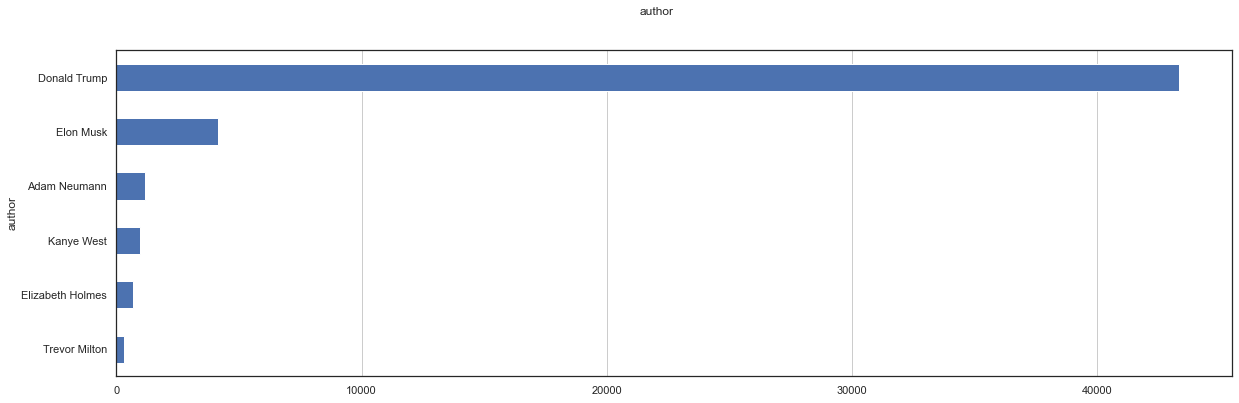

In [15]:
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

fig, ax = plt.subplots(figsize=(20, 6))
fig.suptitle("author", fontsize=12)
data["author"].reset_index().groupby("author").count().sort_values(by="index").plot(
  kind="barh", 
  legend=False,
  ax=ax).grid(axis='x')
plt.show()

Comparing the number of pieces in each corpus, we see our dataset is unbalanced.

A resampling should be done, preferably with this cleanup:

- Drop **stopwords** (e.g. and, are, what)
- **Lemmatize** (e.g. driven will become drive, as driver will result in drive)
- Drop **common words** (i.e. beyond a median frequency)

In [3]:
# Resampled and Normalized
from nltk.stem.wordnet import WordNetLemmatizer
min_rows = data["author"].reset_index().groupby("author").count().min().values[0]

authors = data["author"].unique()
n_df = pd.DataFrame(columns =['author', 'content'])
for author in authors:
  row = data[data["author"] == author].sample(n=min_rows, random_state=RANDOM_STATE)
  n_df = n_df.append(row[['author', 'content']], ignore_index = True)
n_df = n_df.dropna()

# Tokenize, lemmatize and drop stop words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from collections import Counter

sentim = SentimentIntensityAnalyzer()
stops = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

n_df['n_content'] = n_df["content"].apply(
  lambda x: 
    ' '.join([wnl.lemmatize(token) for token in word_tokenize(x) 
    if token not in stops])
)


Let's scan the again the dataset:

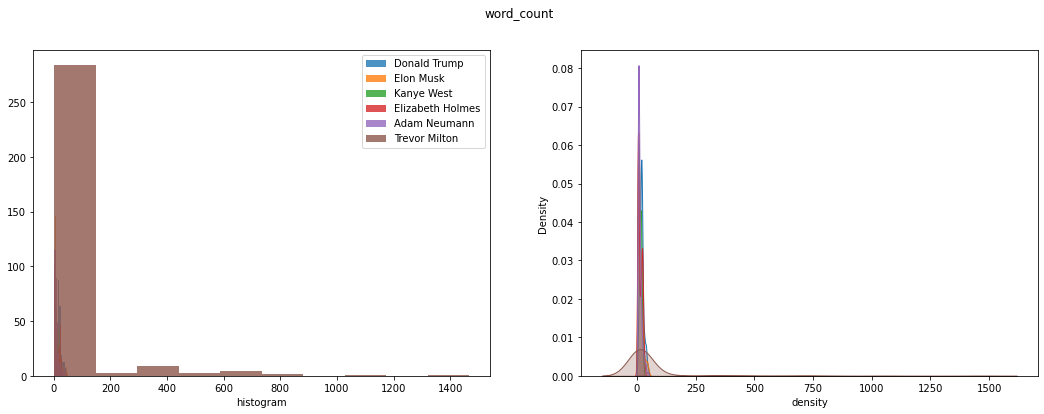

In [4]:
# Analyze length, counts, etc.
n_df['word_count'] = n_df["n_content"].apply(lambda x: len(str(x).split(" ")))
n_df['char_count'] = n_df["n_content"].apply(
    lambda x: sum(len(word) for word in str(x).split(" ")))

x, y = "word_count", "author"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle(x)
for i in authors:
    sns.distplot(n_df[n_df[y] == i][x], hist=True, kde=False,
                 bins=10, hist_kws={"alpha": 0.8},
                 axlabel="histogram", ax=ax[0])
    sns.distplot(n_df[n_df[y] == i][x], hist=False, kde=True,
                 kde_kws={"shade": True}, axlabel="density",
                 ax=ax[1])
ax[0].legend(authors)
plt.show()


There is an common word count of 10 to 30 words. Re-balance again our dataset by sampling only pieces that have an average amount of words that fall in that range.

(886, 3)


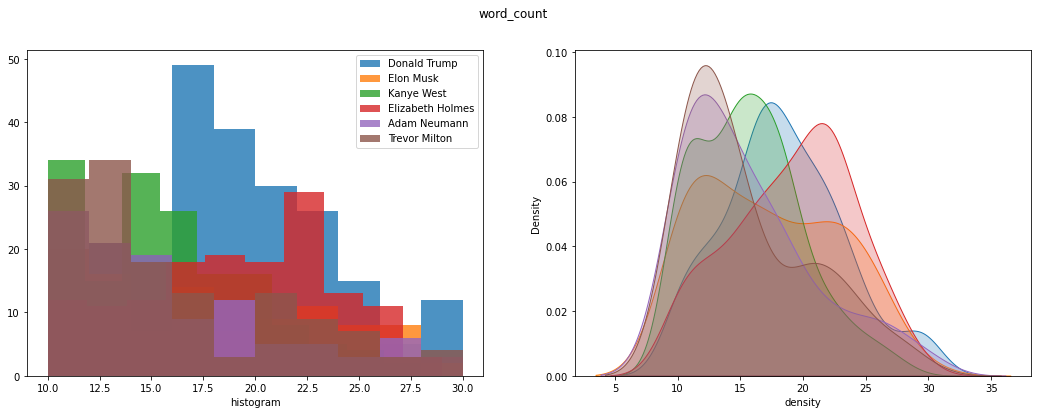

In [5]:
word_df = pd.DataFrame(columns=['author', 'content', 'n_content'])
for author in authors:
  row = n_df[(n_df["author"] == author) & (n_df["word_count"] >= 10) & (n_df["word_count"] <= 30)]
  word_df = word_df.append(row[['author', 'content', 'n_content']], ignore_index=True)
n_df = word_df.dropna()
print(n_df.shape)

n_df['word_count'] = n_df["n_content"].apply(lambda x: len(str(x).split(" ")))
n_df['char_count'] = n_df["n_content"].apply(
    lambda x: sum(len(word) for word in str(x).split(" ")))
    
x, y = "word_count", "author"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle(x)
for i in authors:
    sns.distplot(n_df[n_df[y] == i][x], hist=True, kde=False,
                 bins=10, hist_kws={"alpha": 0.8},
                 axlabel="histogram", ax=ax[0])
    sns.distplot(n_df[n_df[y] == i][x], hist=False, kde=True,
                 kde_kws={"shade": True}, axlabel="density",
                 ax=ax[1])
ax[0].legend(authors)
plt.show()

Do we know what are the most common topics or entities these CEOs mention in their writings? Even better, what feelings did these larger-than-life CEOs had about them.

We will do this using the Named Entity Recognition (**NER**) and **Sentiment Analysis** provided by *scikit-learn*:

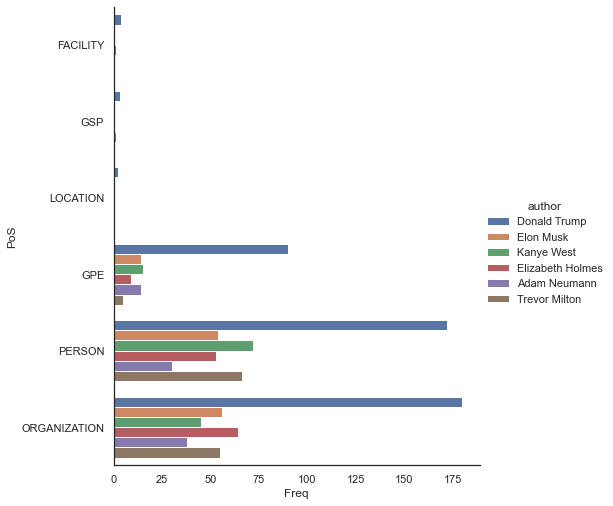

In [6]:

n_df["sentiment"] = n_df['n_content'].apply(
  lambda x:
    sentim.polarity_scores(x)['compound'])

n_df["tags"] = n_df['n_content'].apply(
  lambda x: 
    [t.label() for t in ne_chunk(pos_tag(
      x.split(' '))) if hasattr(t, 'label')])
    
TAG_SET = list(
    set([tag for tags in n_df["tags"] for tag in tags]))
for tag in TAG_SET:
    n_df[tag] = n_df['tags'].map(
        lambda x: x.count(tag) if x is not None and len(x) >= 0 else 0)
n_tags = pd.DataFrame(columns=TAG_SET)
n_df= n_df.drop(columns=["tags"])

sns.set(style="white")
for author in authors:
  temp = pd.DataFrame(n_df[n_df["author"] == author][TAG_SET].sum()).T
  temp['author'] = author
  n_tags = n_tags.append(temp)
temp = n_tags.melt(id_vars="author", var_name="PoS", value_name="Freq")
sns.factorplot(x='Freq', y="PoS", hue="author", data=temp,
               kind='bar', size=7)

Standard NER codes are:

1. **ORGANIZATION** e.g. Microsoft, Facebook
1. **PERSON** e.g. Rafael Nadal, Nelson Mandela
1. **GPE** e.g. India, Australia, South East Asia
1. **GSP** is a Geo-Socio-Political group
1. **LOCATION** e.g. Mount Everest, River Ganga
1. **DATE** e.g. 9th May 1987, 4 AUG

Most of these were already explored in the previous **[article](https://medium.com/call-for-atlas/classifying-social-media-posts-as-hateful-using-nlp-db8f2ba7de58)**.

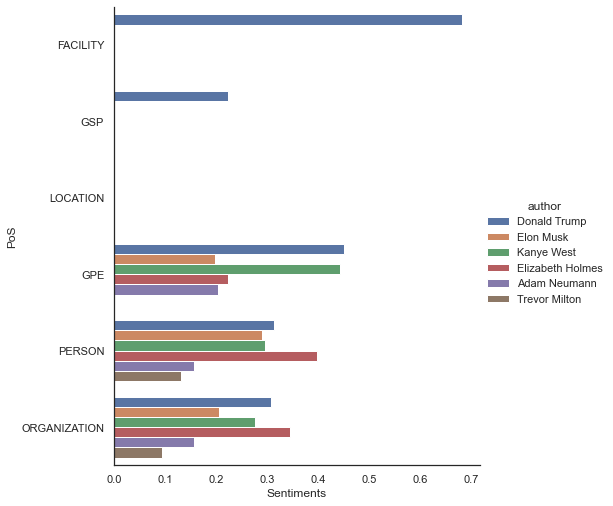

In [7]:
temp = pd.DataFrame(columns=[*TAG_SET, *["author"]])
for author in authors:
  for tag in TAG_SET:
    sent = (n_df[(n_df["author"] == author) & (
        n_df[tag] >= 1)]["sentiment"].mean())
    temp.at[author, tag] = sent if sent > 0 else 0
  temp.at[author, "author"] = author
temp = temp.dropna()

temp = temp.melt(id_vars="author", var_name="PoS", value_name="Sentiments")
sns.factorplot(x='Sentiments', y="PoS", hue="author", data=temp,
               kind='bar', size=7)


A word cloud will allow us to visualize the words themselves (**lemmatized** here) and their relation to others in the dataset:

Wordcloud for: Donald Trump


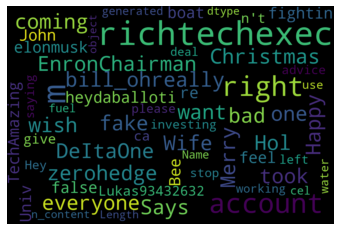

Wordcloud for: Elon Musk


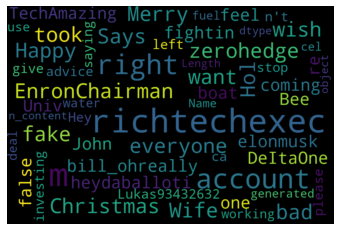

Wordcloud for: Kanye West


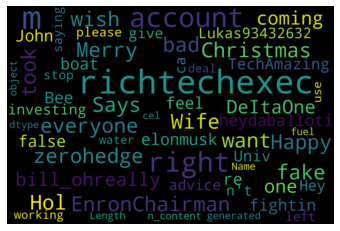

Wordcloud for: Elizabeth Holmes


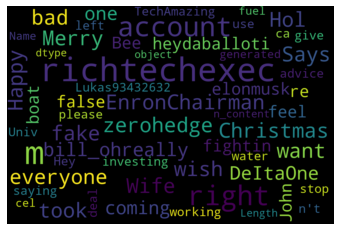

Wordcloud for: Adam Neumann


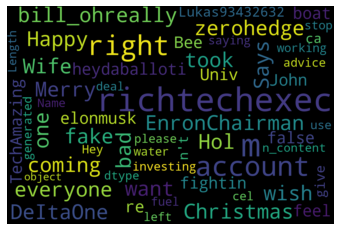

Wordcloud for: Trevor Milton


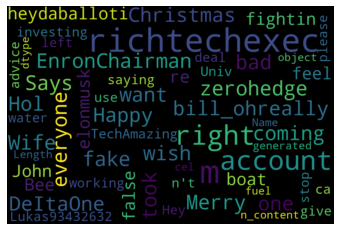

In [8]:
for i in authors:
  print(f'Wordcloud for: {i}')
  
  wc = wordcloud.WordCloud(background_color='black', max_words=200,
                           max_font_size=120, width=1200, height=800)

  corpus = n_df[n_df["author"] == author]['n_content']
  wc = wc.generate(text=str(corpus))
  plt.imshow(wc, cmap=None, interpolation='bilinear')
  
  plt.axis("off")
  plt.show()

## Pipeline and Classifiers to Predict the Author

Now let's build the model.

Using vectors derived from the dataset to act as features, we will apply a stacking classifier. This artefact will combine the best outputs of each classifier to give us an optimal prediction:

In [9]:
# 1
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import StackingClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import *
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
# nltk.download()

# Vectorizing on normalized text above.
vect = CountVectorizer(stop_words='english')
lgc = LogisticRegression(n_jobs=-1, max_iter=1000)
sgdc = SGDClassifier(loss='hinge',
                     penalty='l2',
                     alpha=1e-3,
                     random_state=RANDOM_STATE,
                     tol=None,
                     n_jobs=-1)
estimators = [('sgdc', sgdc), ('lgc', lgc)]
etc = ExtraTreesClassifier(random_state=RANDOM_STATE)
sclf = StackingClassifier(estimators=estimators,
                          final_estimator=lgc,
                          passthrough=True)
tfidf = TfidfTransformer(use_idf=False)

# Pipeline
n_df = n_df.dropna()
y = n_df['author']
X = n_df['n_content']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__sgdc__alpha': (1e-2, 1e-3),
    'clf__sgdc__tol': (0.0, 1e-3),
    'clf__lgc__solver': ['lbfgs', 'sag'],
    'clf__lgc__C': [0.2, 0.7],
    'clf__lgc__penalty': ['c', 'l2']
}

# To find out for the param grid.
# print(text_clf.get_params())
text_clf = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('clf', sclf),
])
gs_clf = GridSearchCV(estimator=text_clf,
                      param_grid=parameters,
                      cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

Vetting the models we stacked:

In [10]:
predicted = gs_clf.predict(X_test)

from sklearn import metrics
print(metrics.classification_report(y_test, predicted,
                                     target_names=y.unique()))

                  precision    recall  f1-score   support

    Donald Trump       0.75      0.46      0.57        26
       Elon Musk       0.78      0.89      0.84        57
      Kanye West       0.82      0.77      0.79        35
Elizabeth Holmes       0.88      0.88      0.88        25
    Adam Neumann       0.71      0.79      0.75        38
   Trevor Milton       0.78      0.78      0.78        32

        accuracy                           0.78       213
       macro avg       0.79      0.76      0.77       213
    weighted avg       0.78      0.78      0.78       213



Above 80% is good enough.

In case you are Vulcan of nature and want near perfect prediction - scikit-learn has a recommendation map to guide you in this task:

![Image: image from sktlearn](ml_map.png "image from tsktlearn")

All things done, let's test it on a sample from this same article- to find out which devise CEO our text's style mostly resembles, and by how much:

In [11]:
text = "In this article, we will entertian ourselves by comparing our's, and, our galatic leaders' posts on the professional network BeamedIn, againts those of past earthling CEOs who were either frauds or unnanimously declared as unpleasant people. We will do this with a technique called ** Authorship Identification ** in NLP. This enables us to identify the most likely author of articles, news or messages. "
toks = [wnl.lemmatize(token) for token in word_tokenize(text) if token not in stops]
text_predicted = gs_clf.predict(toks)
text_predicted_prob = gs_clf.predict_proba(toks)

txt = text_predicted[0]
txt_idx = np.where(authors == txt)

probability = text_predicted_prob[0][txt_idx][0]
print(f'This text is something "{txt}" would write at {probability:.0%}')


This text is something "Donald Trump" would write at 23%


At 60% probability, we might make NLP great again!

![Image: image from Start Trek](bs_alert.png "image from Start Trek")

# Concluding our Analysis

In brief, we explored and cleaned the dataset, ran it through staking classifiers and predicated an author and its probability. I'm a data science amateur, if I can do this so can you!

Live long and prosper - unless - you write, speak and act like Enron's Jeffrey Skilling, then watch out.

## References

- https://www.nltk.org
- https://scikit-learn.org/stable/
- https://www.businesspundit.com/the-worlds-most-controversial-ceos/
- https://en.wikipedia.org/wiki/Q_(Star_Trek)

## Github and Kaggle

Article here is also available on [Github](https://github.com/adamd1985/articles/blob/main/nlp_bs_meter/nlp_intro.ipynb) and [Kaggle](https://www.kaggle.com/code/addarm/authorship-identification-you-vs-ceos)